# Dogs breeds

https://youtu.be/JNxcznsrRb8?t=1h31m8s

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/Users/phaihoang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.set_device(-1)

Kaggle Dog Breed Identification. Get data from https://www.kaggle.com/c/dog-breed-identification

In [4]:
PATH = "data/dogbreed/"
sz = 224
arch = resnet34
bs = 16

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [6]:
n

10222

In [7]:
len(val_idxs)

2044

In [8]:
# If you haven't downloaded weights.tgz yet, download the file.
#     http://forums.fast.ai/t/error-when-trying-to-use-resnext50/7555
#     http://forums.fast.ai/t/lesson-2-in-class-discussion/7452/222
#!wget -O fastai/weights.tgz http://files.fast.ai/models/weights.tgz

#!tar xvfz fastai/weights.tgz -C fastai

## Initial exploration

In [9]:
!ls {PATH}

labels.csv test       tmp        train


In [10]:
label_df = pd.read_csv(label_csv)

In [11]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [12]:
label_df.pivot_table(index="breed", aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [13]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [14]:
fn = PATH + data.trn_ds.fnames[1]; fn

'data/dogbreed/train/001cdf01b096e06d78e9e5112d419397.jpg'

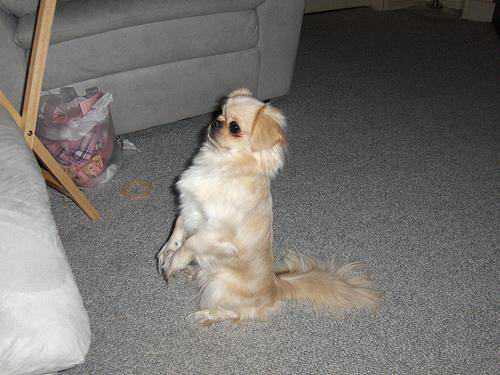

In [15]:
img = PIL.Image.open(fn); img

In [16]:
img.size

(500, 375)

In [17]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [18]:
row_sz, col_sz = list(zip(*size_d.values()))

In [19]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [20]:
row_sz[:5]

array([500, 500, 500, 500, 500])

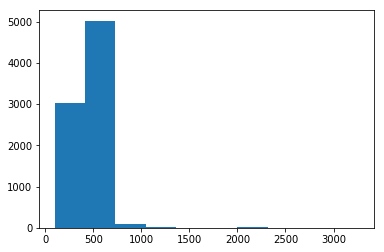

In [21]:
plt.hist(row_sz);

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

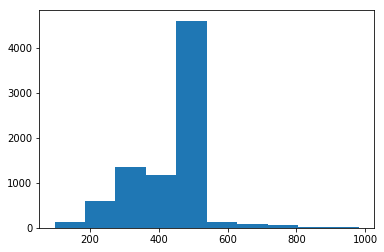

In [22]:
plt.hist(row_sz[row_sz < 1000])

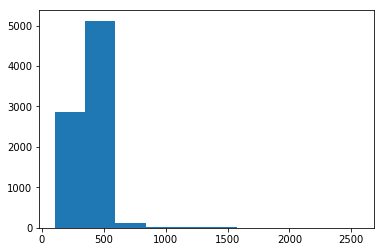

In [23]:
plt.hist(col_sz);

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

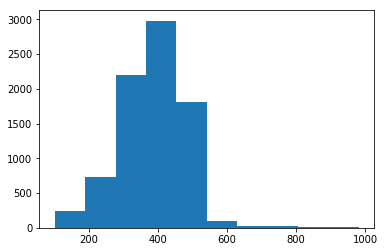

In [24]:
plt.hist(col_sz[col_sz < 1000])

In [25]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [26]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## Initial model

In [27]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

### Precompute

In [28]:
data = get_data(sz, bs)

In [29]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [29]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                     
    0      1.168263   0.651979   0.797945  
    1      0.855151   0.658018   0.794031                     
    2      0.775913   0.588495   0.814579                     
    3      0.608697   0.584768   0.814579                     
    4      0.577979   0.581835   0.825342                     



[0.5818353435881217, 0.8253424658700678]

### Augment

In [30]:
from sklearn import metrics

In [31]:
data = get_data(sz, bs)

In [33]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [34]:
learn.fit(1e-2, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      1.526114   0.901816   0.773483  
    1      1.044993   0.624303   0.813601                    
    2      1.052489   0.565118   0.834149                     
    3      0.909569   0.530118   0.830724                     



[0.5301183861645701, 0.8307240703334547]

In [35]:
learn.precompute = False

In [36]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.942886   0.509317   0.843444  
    1      0.896493   0.514849   0.83317                     
    2      0.904221   0.520042   0.83317                     
    3      0.93138    0.504837   0.836106                    
    4      0.795586   0.522454   0.835127                    



[0.5224544531328571, 0.8351272014489146]

In [37]:
learn.save('224_pre')

In [38]:
learn.load('224_pre')

## Increase size

In [39]:
# Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

# http://forums.fast.ai/t/planet-classification-challenge/7824/96
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, bs)) 
learn.freeze()

#Source:   
#    def set_data(self, data, precompute=False):
#        super().set_data(data)
#        if precompute:
#            self.unfreeze()
#            self.save_fc1()
#            self.freeze()
#            self.precompute = True
#        else:
#            self.freeze()
#File:      ~/fastai/courses/dl1/fastai/conv_learner.py

In [40]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

  0%|          | 2/512 [00:09<42:09,  4.96s/it, loss=0.45] 

Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.

In [32]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy                     
    0      1.2438     0.784892   0.793542  
    1      0.954338   0.598152   0.815068                     
    2      0.741907   0.559008   0.818004                     
    3      0.772111   0.58328    0.812622                     
    4      0.626313   0.532681   0.830724                     
    5      0.529867   0.527499   0.833659                     
    6      0.445617   0.522986   0.839041                     



[0.5229856755343902, 0.8390410960070541]

Training loss and validation loss are getting closer and smaller. We are on right track.

In [33]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.839041095890411, 0.5229856888791727)

In [34]:
len(data.val_ds.y), data.val_ds.y[:5]

(2044, array([19, 15,  7, 99, 73]))

In [35]:
learn.save('299_pre')

In [36]:
learn.load('299_pre')

In [37]:
learn.fit(1e-2, 1, cycle_len=2) # 1+1 = 2 epochs

epoch      trn_loss   val_loss   accuracy                    
    0      0.579454   0.561272   0.825342  
    1      0.483124   0.539139   0.830235                     



[0.5391387857802926, 0.8302348336594912]

In [38]:
learn.save('299_pre')

In [39]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.8302348336594912, 0.5392479601110625)

This dataset is so similar to ImageNet dataset. Training convolution layers doesn't help much. We are not going to unfreeze.

## Create submission

https://youtu.be/9C06ZPF8Uuc?t=1905

In [40]:
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [41]:
data.test_ds.fnames

['test/266490a2b053a4a3bf68e779f28fb5a9.jpg',
 'test/dae9fd18836d8df20989ef0101771d4b.jpg',
 'test/079a40f22b0fad9a66f76797b62bb930.jpg',
 'test/ab8462f9a501d362041d47582fddc9ad.jpg',
 'test/8895089b432e020cc42e6262b5a1c2dd.jpg',
 'test/985ae7fc271ac4a0d131e546c0f95bb6.jpg',
 'test/77c1ab99cffb817d54fb14f229aeb118.jpg',
 'test/ad7e50abca9b7c6a88b63946c5bbe493.jpg',
 'test/d61a09cecf56666cdb315ebce4b93c43.jpg',
 'test/cb120c57904e8c0694bbe259c58a873c.jpg',
 'test/10863e6d9d1cb526cc9d90f30a585719.jpg',
 'test/43cb5f3a505d710bd16e0a0d583a781b.jpg',
 'test/a5aa4e972242a61829ad10b220a12c64.jpg',
 'test/abca35eb197f260e4e348156818bf930.jpg',
 'test/28950f53443e40e5a704a8cb5a1e1d35.jpg',
 'test/326e3c2a0a47f79ad1a87ca5c2f84d79.jpg',
 'test/727fb62505f8fc165a40f755c94e36dd.jpg',
 'test/bccec86223be760e4a9c7899d0628812.jpg',
 'test/42feb15909b1a7da5d85bc1a2baafe47.jpg',
 'test/b8da90f454f62fb33c83715a404aca3b.jpg',
 'test/d38cfa7f70adf71a5c7281f64218034d.jpg',
 'test/b8a3047509bdd743df820c7a6cd

In [43]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)
#accuracy_np(probs, y), metrcs.log_loss(y, probs) # This does not make sense since test dataset has no labels

In [54]:
probs.shape # (n_images, n_classes)

(10357, 120)

In [55]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [56]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [57]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,ab2520c527e61f197be228208af48191,7.957505e-08,2.723862e-08,2.435847e-08,1.173262e-07,2.351215e-08,8.401931e-06,1.372760e-06,6.317406e-08,3.063393e-08,...,2.080939e-08,2.456473e-07,2.722122e-07,5.030101e-08,1.900935e-07,6.053991e-07,3.839476e-08,5.778787e-08,1.575098e-07,1.075539e-08
1,8ffc8a83bb9ac7884a9420c97b23940c,9.668808e-08,2.355516e-08,2.087995e-07,6.298836e-08,3.269388e-08,2.796247e-07,2.439702e-08,2.535878e-06,1.824919e-06,...,4.051576e-08,3.540100e-06,2.388073e-07,9.832689e-01,1.823956e-07,2.486797e-08,8.325348e-08,9.363868e-07,2.608415e-07,3.851193e-07
2,9f4bbcd8a5b189514d3098516983621a,4.214103e-05,2.804878e-04,4.817631e-05,7.178330e-03,1.471457e-06,1.140446e-05,1.950280e-04,7.519415e-06,1.821058e-06,...,5.793181e-05,9.164357e-05,1.187949e-04,6.772134e-06,5.031822e-05,4.772470e-05,6.114125e-06,2.762433e-05,5.382648e-04,2.682866e-05
3,f77793be1597dd1ea50b22532b38bd23,2.568105e-07,2.491144e-07,7.142457e-07,1.466020e-06,3.212435e-05,8.274229e-08,3.600422e-08,6.044879e-08,1.201969e-07,...,2.627351e-06,3.965855e-08,1.560448e-06,6.965169e-08,1.856623e-07,1.051336e-07,1.763770e-07,2.664481e-07,3.316928e-08,9.700193e-08
4,f719b425410b6eb3e3132702150affd6,6.095974e-06,2.696717e-06,4.131879e-06,6.457446e-05,1.191631e-03,3.560664e-05,3.274512e-06,2.229157e-06,1.317608e-06,...,2.345266e-06,1.053057e-05,2.322353e-05,4.169483e-05,1.918868e-05,5.647749e-06,5.437289e-06,5.297930e-06,3.867970e-06,5.011518e-06


In [58]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [59]:
FileLink(f'{SUBM}subm.gz')

/mnt/disc1/fast.ai/fastai/courses/dl1/data/dogbreed/subm/subm.gz

## Individual prediction

In [60]:
fn = data.val_ds.fnames[0]
fn

'train/000bec180eb18c7604dcecc8fe0dba07.jpg'

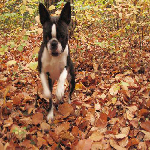

In [61]:
Image.open(PATH + fn).resize((150, 150))

In [62]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

19

In [63]:
learn.data.classes[np.argmax(preds)]

'boston_bull'

In [64]:
# Method 2.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])
np.argmax(preds)

19